1. Data Loading

date       0
Ex_rate    0
dtype: int64
                      date      Ex_rate
count                 7588  7588.000000
mean   2000-05-21 12:00:00     0.776974
min    1990-01-01 00:00:00     0.483297
25%    1995-03-12 18:00:00     0.701422
50%    2000-05-21 12:00:00     0.761377
75%    2005-07-31 06:00:00     0.873477
max    2010-10-10 00:00:00     1.102536
std                    NaN     0.136620


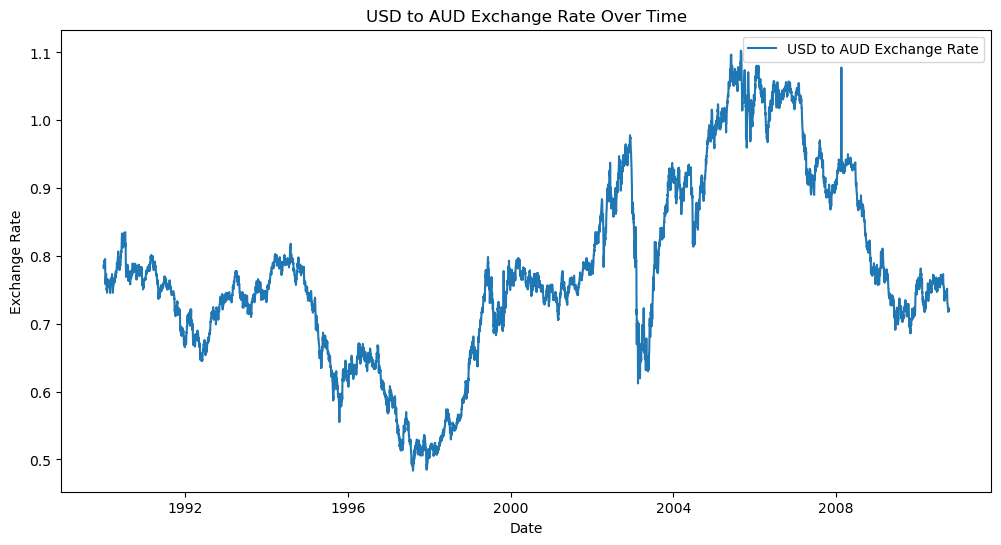

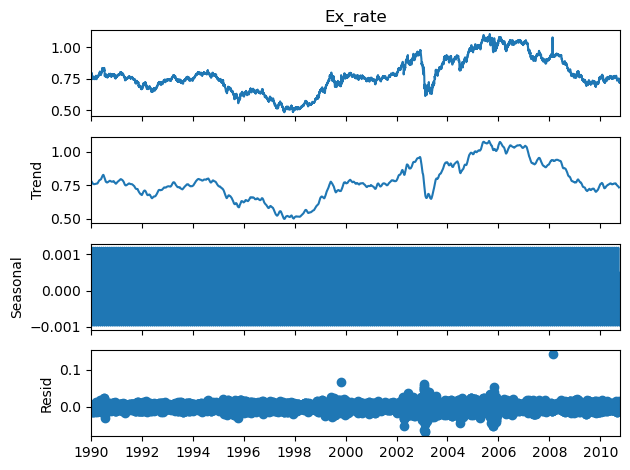

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset with date parsing
df = pd.read_csv("exchange_rate.csv", parse_dates=['date'], dayfirst=True)

# Sort by date
df = df.sort_values('date')

# Check for missing values
print(df.isnull().sum())

# Basic stats
print(df.describe())

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.legend()
plt.show()

# Decompose the time series to observe trend and seasonality
df.set_index('date', inplace=True)
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=30)
decomposition.plot()
plt.show()


2: Model Building - ARIMA

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


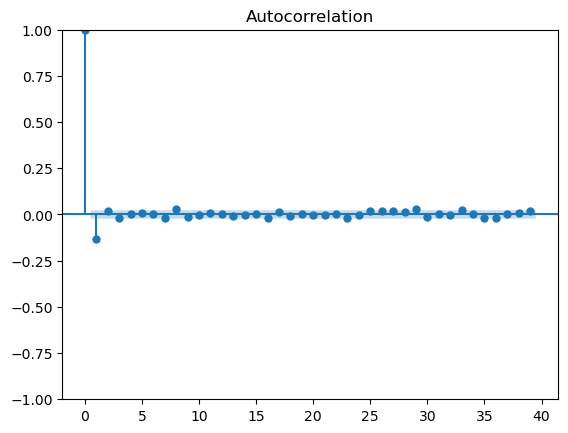

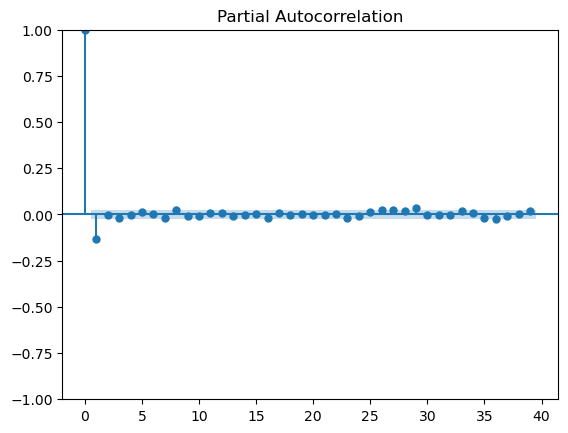

d:\class\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\class\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\class\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 26 Sep 2025   AIC                         -56102.322
Time:                        18:10:28   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

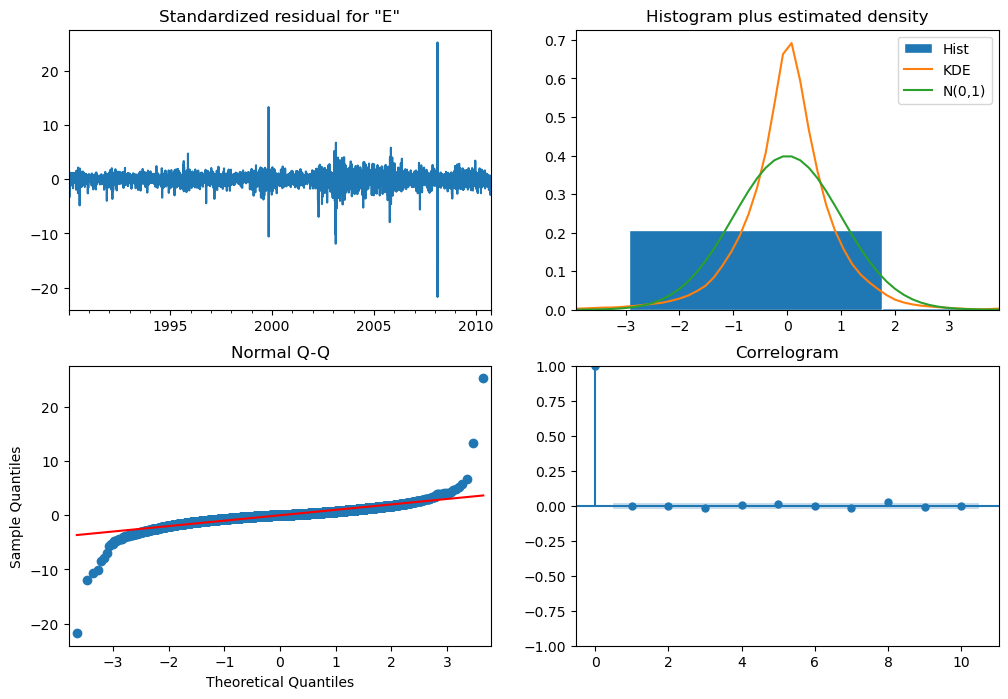

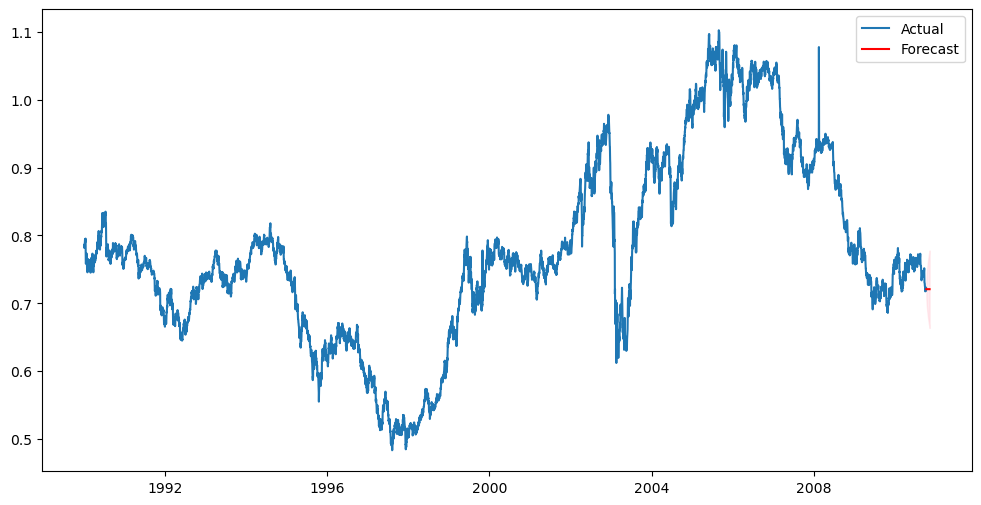

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Check stationarity with ADF test
adf_result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Differencing if needed
df_diff = df['Ex_rate'].diff().dropna()

# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_diff)
plot_pacf(df_diff)
plt.show()

# Fit ARIMA model (example: p=1, d=1, q=1)
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Diagnostics
arima_result.plot_diagnostics(figsize=(12,8))
plt.show()

# Forecast
forecast = arima_result.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.legend()
plt.show()


3: Model Building - Exponential Smoothing

d:\class\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.272
Optimized:                         True   AIC                         -77607.308
Trend:                         Additive   BIC                         -77371.541
Seasonal:                      Additive   AICC                        -77606.955
Seasonal Periods:                    30   Date:                 Fri, 26 Sep 2025
Box-Cox:                          False   Time:                         18:11:26
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8703341                alpha                 True
smoothing_trend          

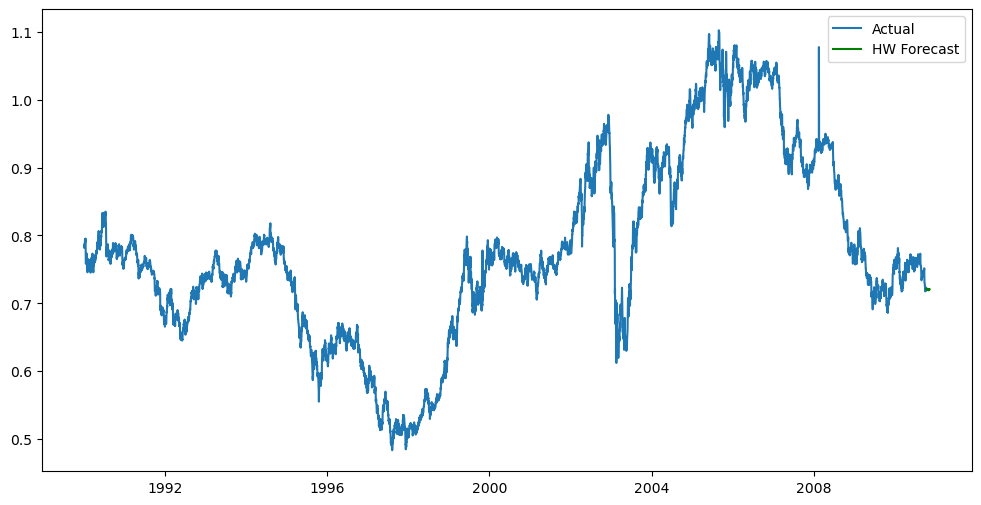

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model (additive trend and seasonality)
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=30)
hw_result = hw_model.fit()
print(hw_result.summary())

# Forecast
hw_forecast = hw_result.forecast(30)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(hw_forecast.index, hw_forecast, label='HW Forecast', color='green')
plt.legend()
plt.show()


4: Evaluation and Comparison

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align forecast with actuals if possible
# Here using in-sample comparison for demonstration
y_true = df['Ex_rate'][-30:]
y_arima = arima_result.predict(start=y_true.index[0], end=y_true.index[-1], dynamic=False)
y_hw = hw_result.predict(start=y_true.index[0], end=y_true.index[-1])

# Error metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

print("ARIMA MAE:", mean_absolute_error(y_true, y_arima))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(y_true, y_arima)))
print("ARIMA MAPE:", mape(y_true, y_arima))

print("Holt-Winters MAE:", mean_absolute_error(y_true, y_hw))
print("Holt-Winters RMSE:", np.sqrt(mean_squared_error(y_true, y_hw)))
print("Holt-Winters MAPE:", mape(y_true, y_hw))


ARIMA MAE: 0.002292431091690269
ARIMA RMSE: 0.003864249147119647
ARIMA MAPE: 0.3126936460868708
Holt-Winters MAE: 0.002328363471364873
Holt-Winters RMSE: 0.003883103851345141
Holt-Winters MAPE: 0.3175676521353089
